# Covid-19: From model prediction to model predictive control

## Calibration of the age-structured deterministic model (2)

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

The original code by Ryan S. McGee implements an SEIRS infectious disease dynamics models with extensions to model the effect of population structure, social distancing, testing, contact tracing, and quarantining of detected cases. The model was implemented using two commonly used frameworks: 1) a deterministic framework represented by a set of ordinary differential equations and 2) a stochastic implementation of these models on dynamic networks. We modified the original implementation by Ryan McGee at its source to account for additional Covid-19 disease characteristics. The deterministic model was extended to model the effect of age-age group interactions, represented by an interaction matrix $N_c$. This was done in analogy to the recently published work of Plem et al (1). The modified implementation of Ryan McGee was then integrated with our previous work and allows to quickly perform Monte Carlo simulations, calibration of model parameters and the calculation of *optimal* government policies using a model predictive controller. A white paper and souce code of our previous work can be found on the Biomath website (2). 

(1) https://www.thelancet.com/journals/lanpub/article/PIIS2468-2667(20)30073-6/fulltext

(2) https://biomath.ugent.be/covid-19-outbreak-modelling-and-control

#### Load required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
import coronaHelper2 as cH
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx
import models
from gekko import GEKKO

#### Define the necessary clinical and testing parameters

In [2]:
# -----------------------
# Define model parameters
# -----------------------

# Clinical parameters
zeta = 0 # re-susceptibility parameter (0 = permanent immunity)
dsm = 14 # length of disease for asymptotic (SM) infections
dm = 14 # length of disease for mildly symptomic infections
dhospital = 9.1 # average time from symptom onset to hospitalisation for H and C infections
dh = 21 # average recovery time for heavy infection
mc0 = 0.49 # mortality for critical cases when they receive care
ICU = 1900 # number of available ICU beds in Belgium

# Testing parameters
totalTests = 0
theta_S = 0 # no. of daily tests of susceptibles 
theta_E = 0 # no. of daily tests of exposed 
theta_SM = 0 # no. of daily tests of SM infected 
theta_M = 0 # no. of daily tests of M infected 
theta_R = 0 # no. of daily tests of recovered patients 
phi_S = 0 # backtracking of susceptibles
phi_E = 0 # backtracking of exposed
phi_SM = 0 # backtracking of supermild cases
phi_R = 0 # backtracking of recovered cases
psi_FP = 0 # odds of a false positive test
psi_PP = 1 # odds of a correct test
dq = 14 # length of quarantine for false positives

## Calibration of disease transmission rate $\beta$

#### Load data

We calibrate to the number of ICU beds taken until March 20th (=index -20).

In [3]:
columns = ['hospital','ICU','dead']
hospital = np.array([[58,97,163,252,361,496,634,837,1089,1380,1643,1859,2152,2652,3042,3717,4138,4524,4920,4995,5376,5552,5678,5735,5840,6012,5688]])
ICUvect= np.array([[5,24,33,53,79,100,130,164,238,290,322,381,474,605,690,789,867,927,1021,1088,1144,1205,1245,1261,1257,1260,1276]])
dead = np.array([[3,4,4,10,10,14,21,37,67,75,88,122,178,220,289,353,431,513,705,828,1011,1143,1283,1447,1632,2035,2240]])
index=pd.date_range('2020-03-13', freq='D', periods=ICUvect.size)
data = np.concatenate((hospital,ICUvect,dead),axis=0)
data = np.transpose(data)
data_belgie=pd.DataFrame(data,index=index, columns=columns)

#### Load and visualise the Belgian interaction matrix $N_c$

<Figure size 432x288 with 0 Axes>

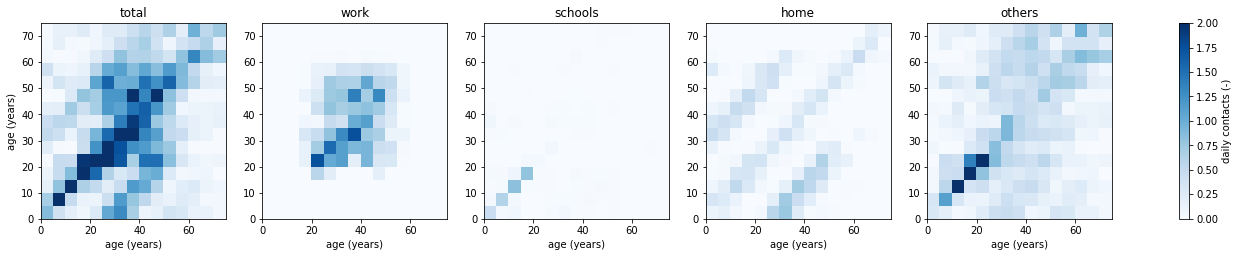

In [4]:
# source: https://github.com/kieshaprem/covid19-agestructureSEIR-wuhan-social-distancing/tree/master/data
Nc_home = np.loadtxt("Belgium/BELhome.txt", dtype='f', delimiter='\t')
Nc_work = np.loadtxt("Belgium/BELwork.txt", dtype='f', delimiter='\t')
Nc_schools = np.loadtxt("Belgium/BELschools.txt", dtype='f', delimiter='\t')
Nc_others = np.loadtxt("Belgium/BELothers.txt", dtype='f', delimiter='\t')
Nc_all = np.loadtxt("Belgium/BELall.txt", dtype='f', delimiter='\t')
initN = np.loadtxt("Belgium/BELagedist.txt", dtype='f', delimiter='\t')

data = [Nc_all,Nc_work,Nc_schools,Nc_home,Nc_others]
titles = ['total','work','schools','home','others']
x = np.linspace(0,75,16)
y = np.linspace(0,75,16)
X, Y = np.meshgrid(x, y)

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=5)
fig.set_size_inches(24,3.6)

i = 0
for ax in axes.flat:
    im = ax.pcolor(x,y,data[i], vmin=0, vmax=2,cmap='Blues')
    if i == 0:
        ax.set_ylabel('age (years)')
    ax.set_title(titles[i])
    ax.set_xlabel('age (years)')
    i = i+1

fig.colorbar(im, ax=axes.ravel().tolist(),label='daily contacts (-)')
fig.savefig('BELinteractPlot.svg', dpi=100,bbox_inches='tight')

In [21]:
Nc = Nc_all # Business-as-usual interaction
betaZonderIngrijpen=[]

#### Perform fit

In [22]:
# -------------------------------
# Parameters of fitting algorithm
# -------------------------------
monteCarlo = True
n_samples = 50
maxiter=30
popsize=5
polish=True
disp = True
bounds=[(0.01,0.05),(1,60)]
idx=-20
print(index[idx])
idx = idx+1
data=np.transpose(ICUvect[:,0:idx])
method = 'findTime'
modelType = 'deterministic'
checkpoints=None
fitTo = np.array([8]) #positions in output of runSimulation that must be added together, here: CH

# -----------
# Perform fit
# -----------
estimate = cH.modelFit(bounds,data,fitTo,initN,Nc,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,theta_R,totalTests,psi_FP,psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,monteCarlo,n_samples,method,modelType,checkpoints,disp,polish,maxiter,popsize)
betaZonderIngrijpen.append(estimate[0])
# print(estimate)

2020-03-20 00:00:00
differential_evolution step 1: f(x)= 21491
differential_evolution step 2: f(x)= 3815.79
differential_evolution step 3: f(x)= 3815.79


Process ForkPoolWorker-18:
Process ForkPoolWorker-16:
Process ForkPoolWorker-19:
Process ForkPoolWorker-20:
Process ForkPoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/proces

  File "/home/twallema/Documents/PhD/Corona/Python/corona model v2/models.py", line 219, in <lambda>
    self.dhospital,self.dh,self.dcf,self.dcr,self.mc0,self.ICU,self.totalTests,self.psi_FP,self.psi_PP,self.dq),
  File "/home/twallema/Documents/PhD/Corona/Python/corona model v2/models.py", line 219, in <lambda>
    self.dhospital,self.dh,self.dcf,self.dcr,self.mc0,self.ICU,self.totalTests,self.psi_FP,self.psi_PP,self.dq),
  File "/home/twallema/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/home/twallema/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/home/twallema/Documents/PhD/Corona/Python/corona model v2/models.py", line 176, in system_dfes
    dSM = sm/sigma*E - SM/dsm - theta_SM*psi_PP*SM #- phi_SM*numpy.matmul(Nc,((SQ+EQ+SMQ+MQ+RQ)/N)*SM)
  File "/home/twallema/anaconda3/lib/python3.7/site-packages/scipy/optimize/_diff

KeyboardInterrupt: 

#### Visualise fit

In [ ]:
# -----------------------
# Fitted model parameters
# -----------------------
estimate = [0.03215578, 26.61816719]
beta = estimate[0]
extraTime = estimate[1]
simtime=data.size+int(extraTime)-1
method = 'none'

# inital condition
initN = initN
initE = np.ones(Nc.shape[0])
initSM = np.zeros(Nc.shape[0])
initM = np.zeros(Nc.shape[0])
initH = np.zeros(Nc.shape[0])
initC = np.zeros(Nc.shape[0])
initHH = np.zeros(Nc.shape[0])
initCH = np.zeros(Nc.shape[0])
initR = np.zeros(Nc.shape[0])
initF = np.zeros(Nc.shape[0])
initSQ = np.zeros(Nc.shape[0])
initEQ = np.zeros(Nc.shape[0])
initSMQ = np.zeros(Nc.shape[0])
initMQ = np.zeros(Nc.shape[0])
initRQ = np.zeros(Nc.shape[0])    

# --------------
# Run simulation
# --------------
simout = cH.simModel(initN,beta,Nc,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,
                     theta_R,totalTests,psi_FP,psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,initE, initSM, initM, initH, initC, 
                    initHH,initCH,initR,initF,initSQ,initEQ,initSMQ,initMQ,initRQ,simtime,monteCarlo,
                     n_samples,method,modelType,checkpoints)

# -----------
# Plot result
# -----------
t=pd.date_range('2020-03-13', freq='D', periods=data.size)
tacc=pd.date_range('2020-03-13', freq='D', periods=data.size+int(extraTime))-datetime.timedelta(days=int(extraTime)-1)
fig=plt.figure(1)
plt.figure(figsize=(7,5),dpi=100)
plt.scatter(t,data_belgie.iloc[:idx,1],color="black",marker="v")
plt.scatter(t,data_belgie.iloc[:idx,2],color="black",marker="o")
plt.scatter(t,data_belgie.iloc[:idx,0],color="black",marker="s")

plt.plot(tacc,np.mean(simout['HH']+simout['CH'],axis=1),'--',color="green")
plt.fill_between(tacc,np.percentile(simout['HH']+simout['CH'],95,axis=1),
                 np.percentile(simout['HH']+simout['CH'],5,axis=1),color="green",alpha=0.2)

plt.plot(tacc,np.mean(simout['CH'],axis=1),'--',color="orange")
plt.fill_between(tacc,np.percentile(simout['CH'],95,axis=1),
                 np.percentile(simout['CH'],5,axis=1),color="orange",alpha=0.2)

plt.plot(tacc,np.mean(simout['F'],axis=1),'--',color="red")
plt.fill_between(tacc,np.percentile(simout['F'],95,axis=1),
                 np.percentile(simout['F'],5,axis=1),color="red",alpha=0.20)
plt.legend(('Hospital (model)','ICU (model)','Deaths (model)'),loc='upper left')

plt.xlim(pd.to_datetime(tacc[24]),pd.to_datetime(tacc[-1]))
plt.title('Belgium',{'fontsize':18})
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.ylabel('number of patients')

plt.savefig('belgiumFit.svg',dpi=100,bbox_inches='tight')

## Calibrate social distancing parameter

By fitting our model to the number of ICU beds occupied during the initial days of the outbreak, we obtained a reliable estimate of $\beta$. This parameter is a disease characteristic and represents the odds of contrapting the disease when coming into contact with an infected person. All contacts in our model are random (assumption of homogeneous mixing) and the disease is assumed to have the same characteristics for all ages. The contact matrices allow us to simulate the effect of concrete policies such as schools closure, working at home, etc. However, when simulating the model with everyone being at home (no school, no work and no others), it is impossible to flatten the peak. This is caused by the fact that all contact matrices were obtained under a business-as-usual scenario, and do not account for the effect of general social distancing. To include the effect of social distancing, it is necessary to use one extra parameter, $\chi$, to model the effect of lower network connectivity. As the peak is flattening in Belgium, it is possible to calibrate $\chi$ using the ICU vs. time data from Belgium. To model the effect of Belgian government policy, we construct an artificial interaction matrix $N_{\text{c, total}}$ of the following form,

\begin{equation}
N_{\text{c, total}} = N_{\text{c, home}} + (1-x_s)*N_{\text{c, schools}} + \chi*(1-x_w)*N_{\text{c, work}} + \chi*(1-x_o)*N_{\text{c, others}}.
\end{equation}

In this equation, the total interaction matrix is a linear combination of the four individual contributions, $N_{\text{c, home}}$, $N_{\text{c, schools}}$, $N_{\text{c, work}}$ and $N_{\text{c, others}}$. In the above equation $x_s$ represents the reduction of contacts on schools. Since schools are closed, $x_s = 1$ and the contribution of $N_{\text{c, schools}}$ drops out of the equation. Note there is no social distancing parameter at home or in school. This is done on purpose because it is impossible to practice social distancing at home and it is highly unlikely that social distancing measures are effective at schools. $x_w$ represents the reduction of contacts at work and is obtained using the Google Covid 19 Community Mobility Report. From the report it can be seen that the fraction of people working at home gradually lowered from 0 to 52% during the week of Monday March 16th (week of announcement government measures). $x_o$ is the fractional reduction of all other contacts and is also estimated using the Google Covid 19 Community Mobility Report. The report shows an 85% decrease for places like restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters. A 53% reduction in grocery markets, food warehouses, farmers markets, specialty food shops, drug stores, and pharmacies. A 66% reduction for places like national parks, public beaches, marinas, dog parks, plazas, and public gardens. And finally a 76% reduction for places like public transport hubs such as subway, bus, and train stations. To obtain an exact number for $x_o$, one would need to know the contribution of each percentage to the total amount of interactions. However, since this data is unavailable we use the average value, $x_o = 0.70$.

Instead of considering step-wise changes of $\chi$, $x_w$ and $x_o$, we assume a two week transition period in which:

- The fraction of people working at home, $x_w$, changes linearly from 0.00 to 0.52 over the course of March 17th untill March 27th. The assumption that transitioning took approximately one to two weeks is backed up by the Google Covid 19 Community Report (see work related mobility stats below).
- The reduction in other contacts, $x_o$, changes from 0.00 to 0.35 on March 15th, and then changes to 0.70 on March 17th. This is done because all restaurants, cinemas, bars, etc. instantly closed on March 15th. On March 17th, all non essential shops were closed too. A more abrupt change in leasure activities is also backed up by the Google Covid 19 Community Report (see retail related mobility stats below).
- The hardest part of modeling the transition period is the gradual increase of public obedience for social distancing measures. It is relatively straightforward to assume that a mentality change in a population as whole is a gradual rather than a stepwise change. We model public obedience as follows: we discretise a two week transition period in 5 intervals, with 4 changes of the social distancing parameters $\chi$. We then use the available data to calibrate the gradual increase in social distancing. Calibration was difficult, so a brute-force approach, rather than a genetic algorithm, was used for the optimisation.

<img src="workGoogleReport.png"
     alt="workGoogleReport"
     height="180" width="500"     
     style="float: left; margin-right: 500px;" /> 

<img src="retailGoogleReport.png"
     alt="retailGoogleReport"
     height="180" width="500"     
     style="float: left; margin-right: 500px;" /> 
https://www.google.com/covid19/mobility/

#### Calibration with a genetic algorithm: DOES NOT WORK WELL

In [21]:
# -------------------------------
# Parameters of fitting algorithm
# -------------------------------
monteCarlo = True
n_samples = 500
maxiter=30
popsize=30
polish=True
disp = True
bounds=[(0.9,1),(0,1),(0,1),(0,1),(0,1)]
data=np.transpose(ICUvect[:,0:])
data = np.append(data,np.ones(3)*data[-1])
data = np.reshape(data,[data.size,1])
method = 'socialInteraction'
modelType = 'deterministic'
fitTo = np.array([8]) #positions in output of runSimulation that must be added together 

# -----------
# Perform fit
# -----------
# chis = cH.modelFit(bounds,data,fitTo,initN,Nc,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,theta_R,psi_FP,psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,monteCarlo,n_samples,method,modelType,checkpoints,disp,polish,maxiter,popsize)
# print(chis)

#### Rather use brute-force approach

In [ ]:
monteCarlo = True
n_samples = 5
data=np.transpose(ICUvect[:,0:])
data = np.append(data,np.ones(5)*data[-1])
data = np.reshape(data,[data.size,1])

x1 = np.linspace(0.05,1,4)
x2 = np.linspace(0.05,1,4)
x3 = np.linspace(0.05,1,4)
x4 = np.linspace(0.05,1,4)

# monte-carlo sampling
sigma = cH.sampleFromDistribution('corona_incubatie.csv',n_samples)
dcf = np.random.normal(18.5, 5.2, n_samples)
dcr = np.random.normal(22.0, 5.2, n_samples)
sm = np.random.normal(0.86, 0.04/1.96, n_samples)
m = (1-sm)*0.81
h = (1-sm)*0.14
c = (1-sm)*0.05
dhospital = np.random.normal(9.10, 0.50/1.96, n_samples) 

# no monte-carlo sampling
# sigma = 5.2
# dcf = 18.5 
# dcr = 22.0
# sm = 0.86
# m = (1-sm)*0.81 
# h = (1-sm)*0.14 
# c = (1-sm)*0.05
# dhospital = 9.1

stoArgs = None
method = 'socialInteraction'
SSE = np.zeros((x1.size,x2.size,x3.size,x4.size))
for i in range(x1.size):
    for j in range(x2.size):
        for k in range(x3.size):
            for l in range(x4.size):
                thetas=np.array([x1[i],x2[j],x3[k],x4[l]])
                checkpoints={
                             't':  [26,29,29+5,29+10,29+15],
                             'Nc': [Nc_all-Nc_schools,
                                     Nc_home + thetas[0]*(1-0.20)*Nc_work + thetas[0]*(1-0.70)*Nc_others,
                                     Nc_home + thetas[1]*(1-0.40)*Nc_work + thetas[1]*(1-0.70)*Nc_others,
                                     Nc_home + thetas[2]*(1-0.52)*Nc_work + thetas[2]*(1-0.70)*Nc_others,
                                     Nc_home + thetas[3]*(1-0.52)*Nc_work + thetas[3]*(1-0.70)*Nc_others]
                             }
                SSE[i,j,k,l] = cH.LSQ(thetas,data,fitTo,
                                    initN,sigma,Nc,zeta,sm,m,h,c,dsm,dm,dhospital,dh,
                                    dcf,dcr,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,theta_R,
                                    psi_FP,psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,monteCarlo,method,
                                    modelType,checkpoints,stoArgs)
print(np.where(SSE == SSE.min()))
sol=SSE.min()
print(sol)

#### Visualise fit

In [214]:
# Load the fitted parameters
Nc=Nc_all
beta = estimate[0]
extraTime = estimate[1]
# inital condition
initN = initN
initE = np.ones(Nc.shape[0])
initSM = np.zeros(Nc.shape[0])
initM = np.zeros(Nc.shape[0])
initH = np.zeros(Nc.shape[0])
initC = np.zeros(Nc.shape[0])
initHH = np.zeros(Nc.shape[0])
initCH = np.zeros(Nc.shape[0])
initR = np.zeros(Nc.shape[0])
initF = np.zeros(Nc.shape[0])
initSQ = np.zeros(Nc.shape[0])
initEQ = np.zeros(Nc.shape[0])
initSMQ = np.zeros(Nc.shape[0])
initMQ = np.zeros(Nc.shape[0])
initRQ = np.zeros(Nc.shape[0])   

# --------------
# Run simulation
# --------------
method='none'
simtime = 80
#chis=np.array([1,0.34,0.34,0.01]) #werkt goed
chis=np.array([1,0.68,0.34,0.02])

checkpoints={
    't':  [26,29,29+5,29+10,29+15],
    'Nc': [Nc_all-Nc_schools,
            Nc_home + chis[0]*(1-0.20)*Nc_work + chis[0]*(1-0.70)*Nc_others,
            Nc_home + chis[1]*(1-0.40)*Nc_work + chis[1]*(1-0.70)*Nc_others,
            Nc_home + chis[2]*(1-0.52)*Nc_work + chis[2]*(1-0.70)*Nc_others,
            Nc_home + chis[3]*(1-0.52)*Nc_work + chis[3]*(1-0.70)*Nc_others]
}

monteCarlo=True
n_samples=200
simout = cH.simModel(initN,beta,Nc,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,
                     theta_R,psi_FP,psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,initE, initSM, initM, initH, initC, 
                    initHH,initCH,initR,initF,initSQ,initEQ,initSMQ,initMQ,initRQ,simtime,monteCarlo,
                     n_samples,method,modelType,checkpoints)

<Figure size 432x288 with 0 Axes>

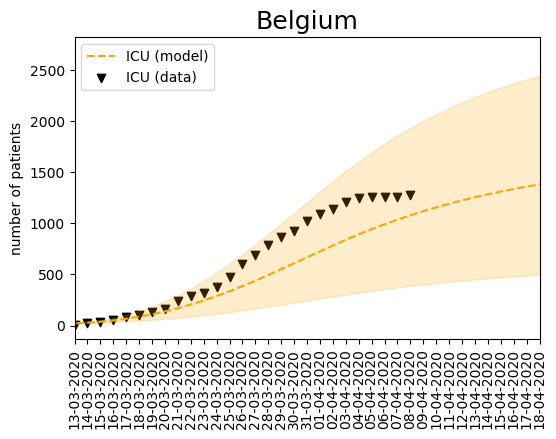

In [215]:
# -----------
# Plot result
# -----------

t=pd.date_range('2020-03-13', freq='D', periods=ICUvect.size)
tacc=pd.date_range('2020-03-13', freq='D', periods=simtime+1)-datetime.timedelta(days=int(extraTime)-1)

fig=plt.figure(1)
plt.figure(figsize=(6,4),dpi=100)
plt.scatter(t,data_belgie.iloc[:,1],color="black",marker="v")
plt.plot(tacc,np.mean(simout['CH'],axis=1),'--',color="orange")
plt.fill_between(tacc,np.percentile(simout['CH'],95,axis=1),
                 np.percentile(simout['CH'],5,axis=1),color="orange",alpha=0.2)
plt.legend(('ICU (model)','ICU (data)'),loc='upper left')
plt.xlim(pd.to_datetime(tacc[25]),pd.to_datetime(tacc[-20]))
plt.title('Belgium',{'fontsize':18})
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
#plt.gca().xaxis.set_minor_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 90)
plt.ylabel('number of patients')

plt.savefig('belgiumICUfit.svg',dpi=100,bbox_inches='tight')

## Controller

#### Messing around

In [205]:
modelType = 'deterministic'
method = 'none'

In [206]:
monteCarlo = False
n_samples=1000
# initE = np.ones(16)*100
# initN = initN
period = 7
P = 8
N = 6
discrete=True
ICU = 1000

In [207]:
# inital condition
initN = initN
initE = np.ones(Nc.shape[0])*np.mean(simout['E'],axis=1)[-1]/16
initSM = np.ones(Nc.shape[0])*np.mean(simout['SM'],axis=1)[-1]/16
initM = np.ones(Nc.shape[0])*np.mean(simout['M'],axis=1)[-1]/16
initH = np.ones(Nc.shape[0])*np.mean(simout['H'],axis=1)[-1]/16
initC = np.ones(Nc.shape[0])*np.mean(simout['C'],axis=1)[-1]/16
initHH = np.ones(Nc.shape[0])*np.mean(simout['HH'],axis=1)[-1]/16
initCH = np.ones(Nc.shape[0])*np.mean(simout['CH'],axis=1)[-1]/16
initR = np.ones(Nc.shape[0])*np.mean(simout['R'],axis=1)[-1]/16
initF = np.ones(Nc.shape[0])*np.mean(simout['F'],axis=1)[-1]/16
initSQ = np.ones(Nc.shape[0])*np.mean(simout['SQ'],axis=1)[-1]/16
initEQ = np.ones(Nc.shape[0])*np.mean(simout['EQ'],axis=1)[-1]/16
initSMQ = np.ones(Nc.shape[0])*np.mean(simout['SMQ'],axis=1)[-1]/16
initMQ = np.ones(Nc.shape[0])*np.mean(simout['MQ'],axis=1)[-1]/16
initRQ = np.ones(Nc.shape[0])*np.mean(simout['RQ'],axis=1)[-1]/16  

polish=True
disp = True
maxiter = 80
popsize = 15

policy,thetas = cH.MPCoptimizeAge(initN,beta,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,theta_R,
                           psi_FP,psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,initE, initSM, initM, initH, initC,initHH,initCH,initR,initF,initSQ,
                           initEQ,initSMQ,initMQ,initRQ,simtime,monteCarlo,n_samples,method,modelType,discrete,
                           period,P,N,disp,polish,maxiter,popsize)

print(policy,thetas)

differential_evolution step 1: f(x)= 1.13248e+08
differential_evolution step 2: f(x)= 1.07467e+08
differential_evolution step 3: f(x)= 1.06177e+08
differential_evolution step 4: f(x)= 1.04603e+08
differential_evolution step 5: f(x)= 1.04603e+08
differential_evolution step 6: f(x)= 1.04603e+08
differential_evolution step 7: f(x)= 1.01492e+08
differential_evolution step 8: f(x)= 1.01492e+08
differential_evolution step 9: f(x)= 1.01492e+08
differential_evolution step 10: f(x)= 1.01492e+08
differential_evolution step 11: f(x)= 1.01492e+08
differential_evolution step 12: f(x)= 1.01492e+08
differential_evolution step 13: f(x)= 1.01492e+08
differential_evolution step 14: f(x)= 1.01492e+08
differential_evolution step 15: f(x)= 1.01492e+08
differential_evolution step 16: f(x)= 1.01492e+08
differential_evolution step 17: f(x)= 1.01492e+08
differential_evolution step 18: f(x)= 1.01492e+08
differential_evolution step 19: f(x)= 1.01492e+08
differential_evolution step 20: f(x)= 1.01492e+08
different

In [210]:
checkpoints = cH.constructHorizonAge(policy,period)
policyVect = cH.constructHorizonPlot(thetas,period)
simtime = len(policy)*period
# --------------
# Run simulation
# --------------
monteCarlo=True
n_samples=200
Nc = Nc_home + 0.01*(1-0.52)*Nc_work + 0.01*(1-0.70)*Nc_others # Eerste checkpoint is maar na 7 dagen
simout = cH.simModel(initN,beta,Nc,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,
                     theta_R,psi_FP,psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,initE, initSM, initM, initH, initC, 
                    initHH,initCH,initR,initF,initSQ,initEQ,initSMQ,initMQ,initRQ,simtime,monteCarlo,
                     n_samples,method,modelType,checkpoints)

Text(0, 0.5, 'Daily random social interactions')

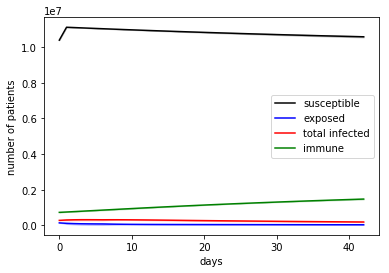

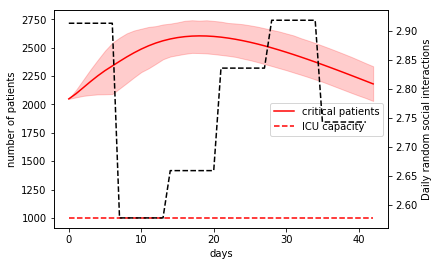

In [211]:
# -----------
# Plot result
# -----------
t = simout['t']
I = simout['SM']+ simout['M'] + simout['H'] + simout['C'] + simout['HH'] + simout['CH']

plt.figure(1)
plt.plot(t,np.mean(simout['S'],axis=1),color="black")
plt.fill_between(t, np.percentile(simout['S'],90,axis=1), np.percentile(simout['S'],10,axis=1),color="black",alpha=0.2)
plt.plot(t,np.mean(simout['E'],axis=1),color="blue")
plt.fill_between(t, np.percentile(simout['E'],90,axis=1), np.percentile(simout['E'],10,axis=1),color="blue",alpha=0.2)
plt.plot(t,np.mean(I,axis=1),color="red")
plt.fill_between(t, np.percentile(I,90,axis=1), np.percentile(I,10,axis=1),color="red",alpha=0.2)
plt.plot(t,np.mean(simout['R'],axis=1),color="green")
plt.fill_between(t, np.percentile(simout['R'],90,axis=1), np.percentile(simout['R'],10,axis=1),color="green",alpha=0.2)
plt.legend(('susceptible','exposed','total infected','immune'))
plt.xlabel('days')
plt.ylabel('number of patients')

plt.figure(2)
plt.plot(t,np.mean(simout['CH'],axis=1),color="red")
plt.fill_between(t, np.percentile(simout['CH'],90,axis=1), np.percentile(simout['CH'],10,axis=1),color="red",alpha=0.2)
plt.plot(t,np.ones([t.size])*ICU,'--',color="red")
plt.legend(('critical patients','ICU capacity'))
plt.xlabel('days')
plt.ylabel('number of patients')
ax2 = plt.twinx()
plt.plot(t[:-1],policyVect[:-1],'--',color='black')
ax2.set_ylabel("Daily random social interactions")

In [217]:
monteCarlo = False
ICU=1000
P = 7
period = 7
x1 = np.linspace(1,3,3)
x2 = np.linspace(1,3,3)
x3 = np.linspace(1,3,3)
x4 = np.linspace(1,3,3)
x5 = np.linspace(1,3,3)
x6 = np.linspace(1,3,3)
SSE = np.zeros((x1.size,x2.size,x3.size,x4.size,x5.size,x6.size))
for i in range(x1.size):
    for j in range(x2.size):
        for k in range(x3.size):
            for l in range(x4.size):
                for m in range(x5.size):
                    for n in range(x6.size):
                        thetas=np.array([x1[i],x2[j],x3[k],x4[l],x5[m],x6[n]])
                        SSE[i,j,k,l,m,n] = cH.MPCcalcWeightsAge(thetas,initN,beta,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,theta_R,psi_FP,psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,initE, initSM, initM, initH, initC, 
                              initHH,initCH,initR,initF,initSQ,initEQ,initSMQ,initMQ,initRQ,simtime,monteCarlo,n_samples,method,modelType,discrete,period,P)
print(np.where(SSE == SSE.min()))

(array([0]), array([0]), array([0]), array([0]), array([0]), array([2]))


In [ ]:
thetas0 = np.array([2,2,2,2,2,2])
Nappend = np.ones([N-thetas0.size])*thetas0[-1]
thetas0 = np.append(thetas0,Nappend)
thetas = scipy.optimize.fmin(cH.MPCcalcWeightsAge, thetas0, args=(initN,beta,zeta,dsm,dm,dhospital,dh,mc0,ICU,
                                                                  theta_S,theta_E,theta_SM,theta_M,theta_R,psi_FP,
                                                                  psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,initE, initSM,
                                                                  initM,initH,initC,initHH,initCH,initR,initF,
                                                                  initSQ,initEQ,initSMQ,initMQ,initRQ,simtime,
                                                                  monteCarlo,n_samples,method,modelType,discrete,
                                                                  period,P), xtol=0.0001, ftol=0.0001, maxiter=10,
                                                                  maxfun=None, full_output=0, disp=1, retall=0,
                                                                  callback=None)  


In [180]:
print(thetas)

[2.        2.        2.        2.        2.05      2.025     2.0125
 2.00625   2.        2.003125  2.0015625 2.0015625]


In [ ]:
thetas=np.array([1,1,1,3,3,3])
Ncs=[]
for i in range(thetas.size):
    if thetas[i]<=1 and thetas[i]>=0:
        Ncs.append(Nc_all)
    elif thetas[i]<=2 and thetas[i]> 1:
        Ncs.append(Nc_home + Nc_schools + 0.01*(1-0.52)*Nc_work + 0.01*(1-0.70)*Nc_others)
    elif thetas[i]<=3 and thetas[i]> 2:
        Ncs.append(Nc_home + 0.01*(1-0.52)*Nc_work + 0.01*(1-0.70)*Nc_others)


In [ ]:
checkpoints = cH.constructHorizonAge(Ncs,period)
policyVect = cH.constructHorizonPlot(thetas,period)
simtime = len(Ncs)*period
# --------------
# Run simulation
# --------------
simout = cH.simModel(initN,beta,Nc,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,
                     theta_R,psi_FP,psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,initE, initSM, initM, initH, initC, 
                    initHH,initCH,initR,initF,initSQ,initEQ,initSMQ,initMQ,initRQ,simtime,monteCarlo,
                     n_samples,method,modelType,checkpoints)

In [ ]:
# -----------
# Plot result
# -----------
t = simout['t']
I = simout['SM']+ simout['M'] + simout['H'] + simout['C'] + simout['HH'] + simout['CH']

plt.figure(1)
plt.plot(t,np.mean(simout['S'],axis=1),color="black")
plt.fill_between(t, np.percentile(simout['S'],90,axis=1), np.percentile(simout['S'],10,axis=1),color="black",alpha=0.2)
plt.plot(t,np.mean(simout['E'],axis=1),color="blue")
plt.fill_between(t, np.percentile(simout['E'],90,axis=1), np.percentile(simout['E'],10,axis=1),color="blue",alpha=0.2)
plt.plot(t,np.mean(I,axis=1),color="red")
plt.fill_between(t, np.percentile(I,90,axis=1), np.percentile(I,10,axis=1),color="red",alpha=0.2)
plt.plot(t,np.mean(simout['R'],axis=1),color="green")
plt.fill_between(t, np.percentile(simout['R'],90,axis=1), np.percentile(simout['R'],10,axis=1),color="green",alpha=0.2)
plt.legend(('susceptible','exposed','total infected','immune'))
plt.xlabel('days')
plt.ylabel('number of patients')

plt.figure(2)
plt.plot(t,np.mean(simout['CH'],axis=1),color="red")
plt.fill_between(t, np.percentile(simout['CH'],90,axis=1), np.percentile(simout['CH'],10,axis=1),color="red",alpha=0.2)
plt.plot(t,np.ones([t.size])*ICU,'--',color="red")
plt.legend(('critical patients','ICU capacity'))
plt.xlabel('days')
plt.ylabel('number of patients')
ax2 = plt.twinx()
plt.plot(t[:-1],policyVect[:-1],'--',color='black')
ax2.set_ylabel("Daily random social interactions")

#### Find the right initial condition

Run Monte Carlo simulation until present day, then assume equal numbers in each age category.

In [134]:
# inital condition
initN = initN
initE = np.ones(Nc.shape[0])*np.mean(simout['E'],axis=1)[-1]/16
initSM = np.ones(Nc.shape[0])*np.mean(simout['SM'],axis=1)[-1]/16
initM = np.ones(Nc.shape[0])*np.mean(simout['M'],axis=1)[-1]/16
initH = np.ones(Nc.shape[0])*np.mean(simout['H'],axis=1)[-1]/16
initC = np.ones(Nc.shape[0])*np.mean(simout['C'],axis=1)[-1]/16
initHH = np.ones(Nc.shape[0])*np.mean(simout['HH'],axis=1)[-1]/16
initCH = np.ones(Nc.shape[0])*np.mean(simout['CH'],axis=1)[-1]/16
initR = np.ones(Nc.shape[0])*np.mean(simout['R'],axis=1)[-1]/16
initF = np.ones(Nc.shape[0])*np.mean(simout['F'],axis=1)[-1]/16
initSQ = np.ones(Nc.shape[0])*np.mean(simout['SQ'],axis=1)[-1]/16
initEQ = np.ones(Nc.shape[0])*np.mean(simout['EQ'],axis=1)[-1]/16
initSMQ = np.ones(Nc.shape[0])*np.mean(simout['SMQ'],axis=1)[-1]/16
initMQ = np.ones(Nc.shape[0])*np.mean(simout['MQ'],axis=1)[-1]/16
initRQ = np.ones(Nc.shape[0])*np.mean(simout['RQ'],axis=1)[-1]/16  

In [137]:
# Define some parameters
monteCarlo = False
n_samples=50
period = 7
P = 8
N = 4
discrete=True
ICU = 1200

# Perform brute force optimisation of horizon
x1 = np.linspace(1,3,3)
x2 = np.linspace(1,3,3)
x3 = np.linspace(1,3,3)
x4 = np.linspace(1,3,3)
x5 = np.linspace(1,3,3)
x6 = np.linspace(1,3,3)
SSE = np.zeros((x1.size,x2.size,x3.size,x4.size,x5.size,x6.size))
for i in range(x1.size):
    for j in range(x2.size):
        for k in range(x3.size):
            for l in range(x4.size):
                for m in range(x5.size):
                    for n in range(x6.size):
                        thetas=np.array([x1[i],x2[j],x3[k],x4[l],x5[m],x6[n]])
                        SSE[i,j,k,l,m,n] = cH.MPCcalcWeightsAge(thetas,initN,beta,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,theta_R,psi_FP,psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,initE, initSM, initM, initH, initC, 
                              initHH,initCH,initR,initF,initSQ,initEQ,initSMQ,initMQ,initRQ,simtime,monteCarlo,n_samples,method,modelType,discrete,period,P)
print(np.where(SSE == SSE.min()))

(array([1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1]), array([0, 0, 0, 1, 1, 1, 2, 2, 2]), array([0, 1, 2, 0, 1, 2, 0, 1, 2]))


In [ ]:
thetas=np.array([1,1,2,1])
Ncs=[]
for i in range(thetas.size):
    if thetas[i]<=1 and thetas[i]>=0:
        Ncs.append(Nc_all)
    elif thetas[i]<=2 and thetas[i]> 1:
        Ncs.append(Nc_home + Nc_schools + 0.01*(1-0.52)*Nc_work + 0.01*(1-0.70)*Nc_others)
    elif thetas[i]<=3 and thetas[i]> 2:
        Ncs.append(Nc_home + 0.01*(1-0.52)*Nc_work + 0.01*(1-0.70)*Nc_others)

In [ ]:
checkpoints = cH.constructHorizonAge(Ncs,period)
Nc = Nc_home + Nc_schools + 0.01*(1-0.52)*Nc_work + 0.01*(1-0.70)*Nc_others # Eerste checkpoint is maar na 7 dagen
policyVect = cH.constructHorizonPlot(thetas,period)
simtime = len(Ncs)*period

monteCarlo=True
n_samples=600
# --------------
# Run simulation
# --------------
simout = cH.simModel(initN,beta,Nc,zeta,dsm,dm,dhospital,dh,mc0,ICU,theta_S,theta_E,theta_SM,theta_M,
                     theta_R,psi_FP,psi_PP,dq,phi_S,phi_E,phi_SM,phi_R,initE, initSM, initM, initH, initC, 
                    initHH,initCH,initR,initF,initSQ,initEQ,initSMQ,initMQ,initRQ,simtime,monteCarlo,
                     n_samples,method,modelType,checkpoints)

In [ ]:
# -----------
# Plot result
# -----------
t = simout['t']
I = simout['SM']+ simout['M'] + simout['H'] + simout['C'] + simout['HH'] + simout['CH']

plt.figure(1)
plt.plot(t,np.mean(simout['S'],axis=1),color="black")
plt.fill_between(t, np.percentile(simout['S'],90,axis=1), np.percentile(simout['S'],10,axis=1),color="black",alpha=0.2)
plt.plot(t,np.mean(simout['E'],axis=1),color="blue")
plt.fill_between(t, np.percentile(simout['E'],90,axis=1), np.percentile(simout['E'],10,axis=1),color="blue",alpha=0.2)
plt.plot(t,np.mean(I,axis=1),color="red")
plt.fill_between(t, np.percentile(I,90,axis=1), np.percentile(I,10,axis=1),color="red",alpha=0.2)
plt.plot(t,np.mean(simout['R'],axis=1),color="green")
plt.fill_between(t, np.percentile(simout['R'],90,axis=1), np.percentile(simout['R'],10,axis=1),color="green",alpha=0.2)
plt.legend(('susceptible','exposed','total infected','immune'))
plt.xlabel('days')
plt.ylabel('number of patients')

plt.figure(2)
plt.plot(t,np.mean(simout['CH'],axis=1),color="red")
plt.fill_between(t, np.percentile(simout['CH'],90,axis=1), np.percentile(simout['CH'],10,axis=1),color="red",alpha=0.2)
plt.plot(t,np.ones([t.size])*ICU,'--',color="red")
plt.legend(('critical patients','ICU capacity'))
plt.xlabel('days')
plt.ylabel('number of patients')
ax2 = plt.twinx()
plt.plot(t[:-1],policyVect[:-1],'--',color='black')
ax2.set_ylabel("Daily random social interactions")